In [1]:
# Load Dependencies
import matplotlib.pyplot as plt

import torch

import pyro
import numpy as np
import pyro.distributions as dist
from pyro.poutine import trace, replay, block
from pyro.infer.autoguide.guides import AutoDelta, AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
# from pyro.optim import Adam

import sys
sys.path.append("../")

from pyciemss.utils import run_inference, get_tspan

import warnings
warnings.filterwarnings('ignore')

/Users/gtpash/miniforge3/envs/CIEMSS_ENV/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Plotting Utilities

def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time /days')
    ax.set_ylabel('Infected (1000s)')
    return ax

def plot_predictive(prediction, tspan, tmin=None, ax=None, alpha=0.2, color="black", **kwargs):
    vars = ["I_obs"]
    
    I_low = torch.quantile(prediction["I_obs"], 0.05, dim=0).detach().numpy()/1000
    I_up = torch.quantile(prediction["I_obs"], 0.95, dim=0).detach().numpy()/1000

    if tmin:
        indeces = tspan >= tmin
    else:
        indeces = torch.ones_like(tspan).bool()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    
    ax.fill_between(tspan[indeces], I_low[indeces], I_up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

def plot_trajectory(data, tspan, ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ax.plot(tspan, data["I_obs"].squeeze().detach().numpy()/1000., color, alpha=alpha, lw=lw, marker=marker, label=label)
    
    return ax

def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='-')

    return ax

In [3]:
# Setup Parameters

observed_tspan = get_tspan(1, 7, 7)
new_tspan = get_tspan(7, 89, 83)
full_tspan = get_tspan(1, 89, 89)

num_samples = 500

# Total population, N.
N = 100000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0 = 0., 81.0, 0., 0.
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 - V0 - R0

# 18 - 24 year olds
I_obs = torch.tensor([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])

initial_state = tuple(torch.as_tensor(s) for s in  (S0, V0, I0, Iv0, R0))
final_observed_state = tuple(torch.as_tensor(s) for s in  (S0, V0, I_obs[-1], Iv0, R0))


# Probabilistic Forecasting - Ignoring Historical Data

In [4]:
from pyciemss.ODE.models import SVIIvR

In [5]:
pyro.set_rng_seed(0)

noisy_ode_model = SVIIvR(N, 
                noise_prior=dist.Uniform(5., 10.),
                beta_prior=dist.Uniform(0.1, 0.3), 
                betaV_prior=dist.Uniform(0.025, 0.05),
                gamma_prior=dist.Uniform(0.05, 0.35),
                gammaV_prior=dist.Uniform(0.1, 0.4),
                nu_prior=dist.Uniform(0.001, 0.01))

In [6]:

ode_model = pyro.do(noisy_ode_model, {"noise_var": torch.tensor([0.000001])})

## Q: "What likely future outcomes does our model imply?"

In [7]:
prior_prediction = Predictive(ode_model, num_samples=num_samples)(initial_state, full_tspan)
single_prediction = Predictive(ode_model, num_samples=1)(initial_state, full_tspan)

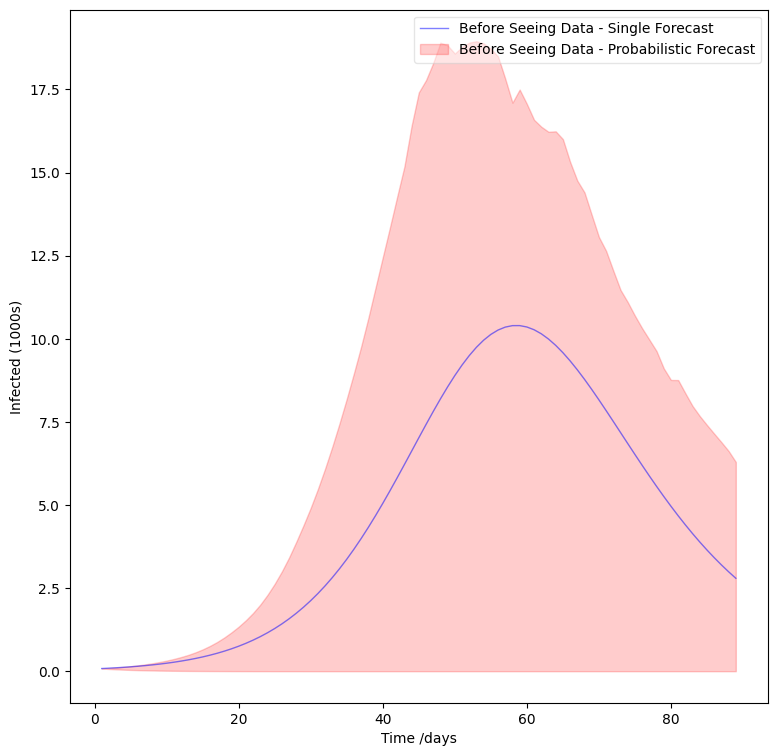

In [8]:

ax = plot_trajectory(single_prediction, full_tspan, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast")
ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")

## Forecasting - Incorporating Historical Data

In [9]:
pyro.set_rng_seed(0)

guide = AutoNormal(block(noisy_ode_model, hide=["S_obs", "V_obs", "R_obs"]))
map_guide = AutoDelta(block(noisy_ode_model, hide=["S_obs", "V_obs", "R_obs"]))

data = {"S_obs":None, "V_obs":None, "I_obs":I_obs, "R_obs":None}

run_inference(noisy_ode_model, guide, initial_state, observed_tspan, data, num_iterations=200, verbose=False)
run_inference(noisy_ode_model, map_guide, initial_state, observed_tspan, data, num_iterations=200, verbose=False)

map_prediction = Predictive(ode_model, guide=map_guide, num_samples=1)(final_observed_state, new_tspan)
posterior_prediction = Predictive(ode_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)

## Q: "What future outcomes are likely given the data we've seen?"

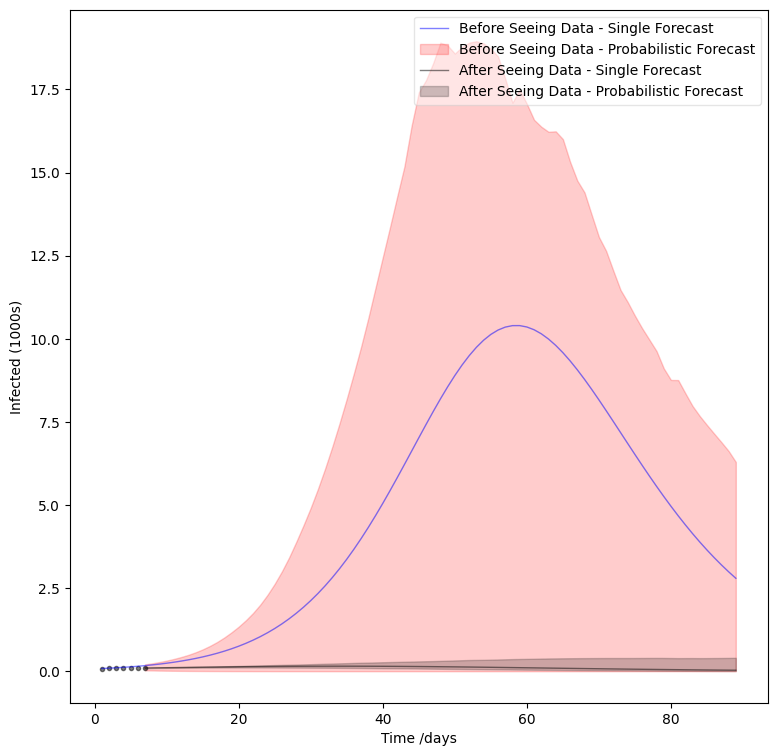

In [10]:

ax = plot_trajectory(data, observed_tspan, ax=setup_ax())
ax = plot_trajectory(single_prediction, full_tspan, ax=ax, color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast")
ax = plot_predictive(prior_prediction, full_tspan, tmin=7, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")
ax = plot_trajectory(map_prediction, new_tspan, ax=ax, marker='', lw=1., label="After Seeing Data - Single Forecast")
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast")

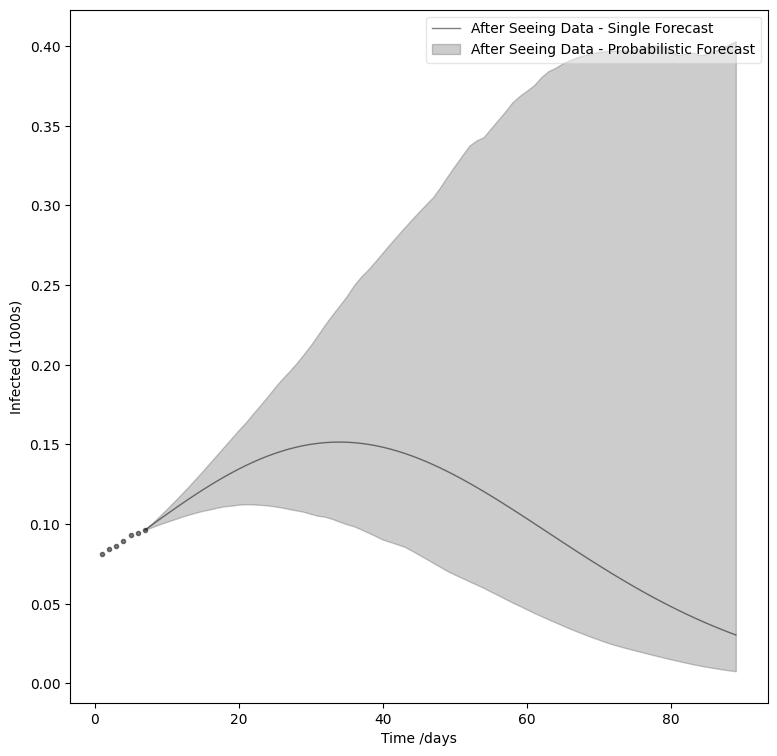

In [11]:

ax = plot_trajectory(data, observed_tspan, ax=setup_ax())
ax = plot_trajectory(map_prediction, new_tspan, ax=ax, marker='', lw=1., label="After Seeing Data - Single Forecast")
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast")

# Probabilistic Forecasting - Exploring Possible Interventions

In [12]:
from causal_pyro.query.do_messenger import do
from pyciemss.ODE.interventions import constant_intervention, time_dependent_intervention, state_dependent_intervention, parameter_intervention

## Q: "What would happen if we set the vaccination rate parameter, $\nu$?"

In [13]:
pyro.set_rng_seed(0)

rate_parameter_intervention = parameter_intervention("nu", torch.tensor([0.01]))
intervened_parameter_model = do(ode_model, rate_parameter_intervention)
intervened_parameter_prediction = Predictive(intervened_parameter_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)

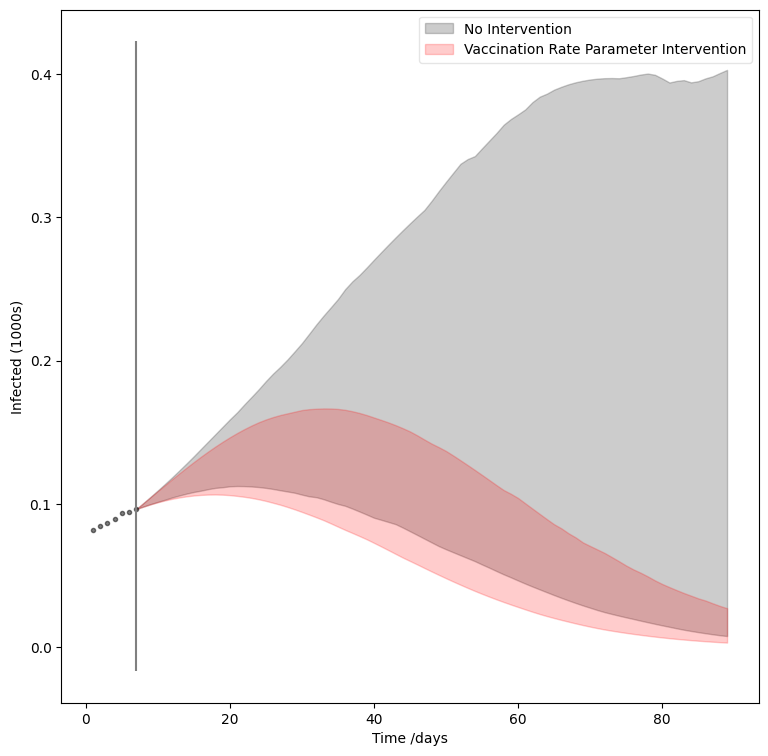

In [14]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, new_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "We can't change the rate parameter directly. Bring me another policy!"
## Q: "What would happen if we set the vaccination rate to a constant 500 people per day?"

In [15]:
pyro.set_rng_seed(0)

rate_intervention = constant_intervention("SV_flux", torch.tensor([500.]), full_tspan)
rate_intervention_model = do(ode_model, rate_intervention)
rate_intervention_prediction = Predictive(rate_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)

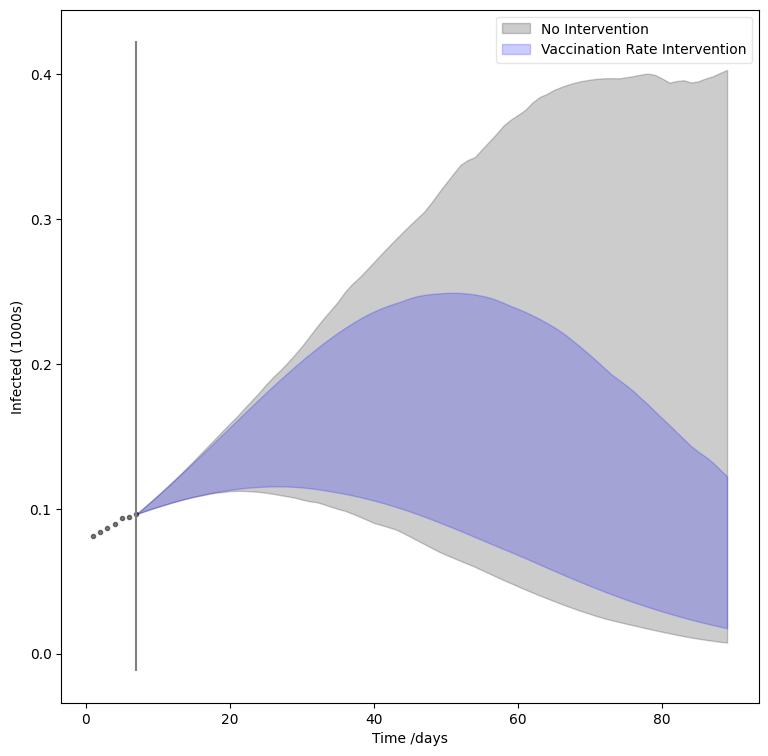

In [16]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(rate_intervention_prediction, new_tspan, ax=ax, color='blue', label="Vaccination Rate Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "We have a lot more vaccines than that, but they aren't available yet!"
## Q: "What would happen if we set the vaccination rate to 500 people per day for the first month, then 750, then 1000?"

In [17]:
pyro.set_rng_seed(0)

def ramping_rate_up_intervention_function(t):
    month = torch.floor(t / 30.).int()
    return torch.tensor([500.0, 750.0, 1000.])[month]

ramping_rate_up_intervention = time_dependent_intervention("SV_flux", ramping_rate_up_intervention_function, new_tspan)
ramping_rate_up_intervention_model = do(ode_model, ramping_rate_up_intervention)
ramping_rate_up_intervention_prediction = Predictive(ramping_rate_up_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)

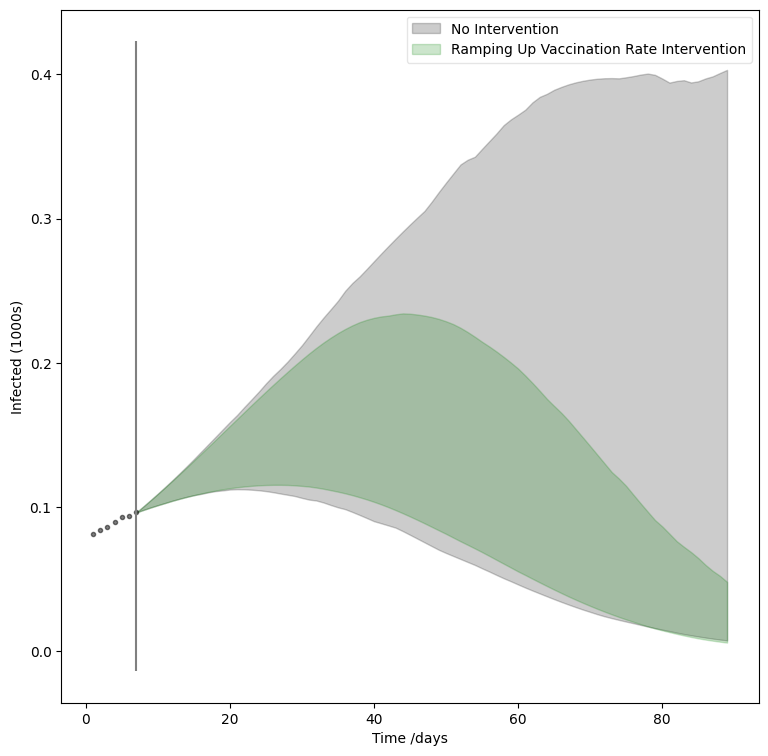

In [18]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(ramping_rate_up_intervention_prediction, new_tspan, ax=ax, color='green', label="Ramping Up Vaccination Rate Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "We can't force people to take a vaccine. Let's run a marketing campaign to encourage vaccination!"
## Q: "What would happen if the marketing campaign convinces 500 **more** people per day to get vaccinated than without it?"

In [19]:
pyro.set_rng_seed(0)

def vaccination_encouragement_intervention_function(SV_flux):
    return SV_flux + torch.tensor([500.])

vaccination_encouragement_intervention = state_dependent_intervention("SV_flux", vaccination_encouragement_intervention_function, new_tspan)
vaccination_encouragement_intervention_model = do(ode_model, vaccination_encouragement_intervention)
vaccination_encouragement_intervention_prediction = Predictive(vaccination_encouragement_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)

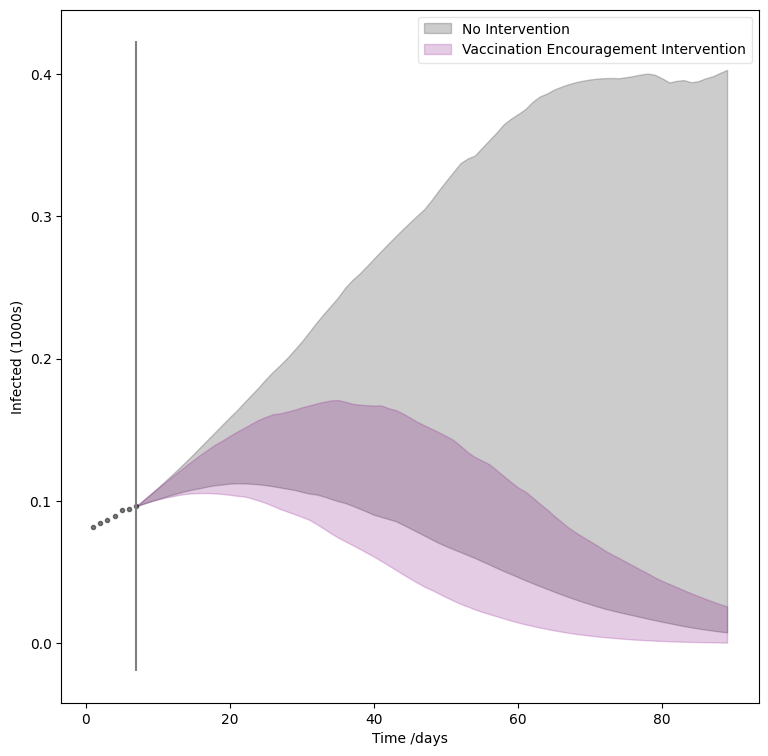

In [20]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, color='black', label="No Intervention")
ax = plot_predictive(vaccination_encouragement_intervention_prediction, new_tspan, ax=ax, color='purple', label="Vaccination Encouragement Intervention")
ax = plot_intervention_line(7., ax=ax)

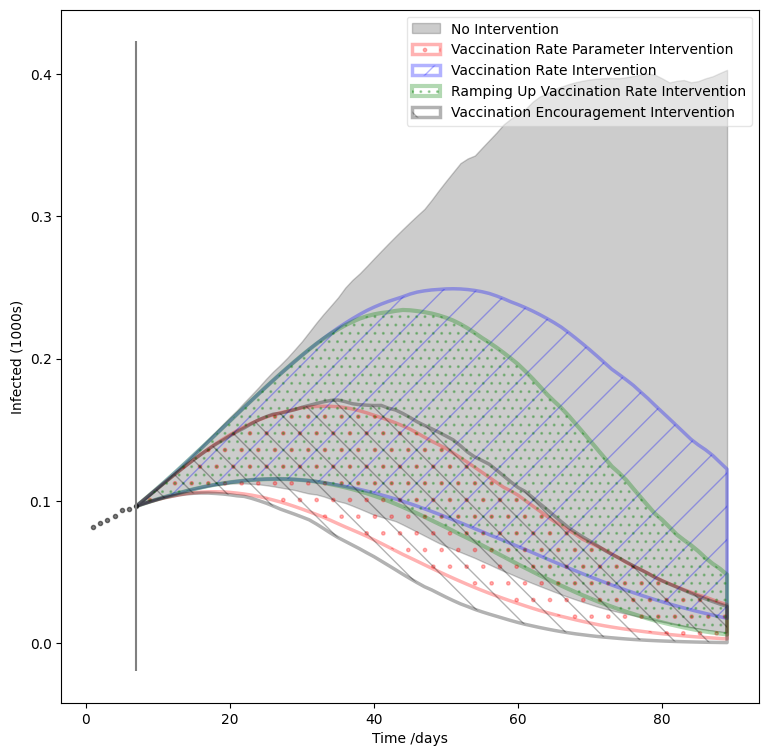

In [21]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, color='black', ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, new_tspan, hatch='.', edgecolor="red", linewidth=2.5, facecolor="none", ax=ax, alpha=0.3, label="Vaccination Rate Parameter Intervention")
ax = plot_predictive(rate_intervention_prediction, new_tspan, hatch='/', ax=ax, alpha=0.3, linewidth=2.5, edgecolor='blue', facecolor="none", label="Vaccination Rate Intervention")
ax = plot_predictive(ramping_rate_up_intervention_prediction, new_tspan, hatch='..', linewidth=3, ax=ax, alpha=0.3, edgecolor='green', facecolor="none", label="Ramping Up Vaccination Rate Intervention")
ax = plot_predictive(vaccination_encouragement_intervention_prediction, new_tspan, hatch="\\", linewidth=2.5, ax=ax, alpha=0.3, edgecolor='black', facecolor="none", label="Vaccination Encouragement Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "Let's only market to young people!"
## Q: "What would happen if the marketing campaign convinces 500 more people age 18-24 per day to get vaccinated than without it?"

In [22]:
pyro.set_rng_seed(0)

stratified_intervention = state_dependent_intervention("SV_flux_18-24", vaccination_encouragement_intervention_function, new_tspan)
stratified_intervention_model = do(ode_model, stratified_intervention)

In [23]:
# NOTE: uncommenting this cell will stop the notebook
# # import sys
# ipython = get_ipython()

# def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
#                    exception_only=False, running_compiled_code=False):
#     etype, value, tb = sys.exc_info()
#     value.__cause__ = None  # suppress chained exceptions
#     return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

# ipython.showtraceback = hide_traceback

# raise ValueError("The Intervention Variable SV_flux_18-24 is not defined and can not be intervened on. To fix this error, revise the model to include SV_flux_18-24").with_traceback(None) from None

In [24]:



# # (experimental conditions, replicates, attributes, timesteps,)
# data_cube = torch.zeros((5, 500, 4, 83))

# for i, var in enumerate(["S_obs", "V_obs", "I_obs", "R_obs"]):
#     for j, prediction in enumerate([posterior_prediction, intervened_parameter_prediction, rate_intervention_prediction, ramping_rate_up_intervention_prediction, vaccination_encouragement_intervention_prediction]):
#         data_cube[j, :, i, :] = prediction[var]

# data_cube = data_cube.detach().numpy()

# import numpy as np
# import pickle

# np.save("datacube.npy", data_cube)

# d = {"experimental conditions":["no_intervention", "intervened_parameter", "intervened_rate", "ramping_intervention", "encouragement_interventions"],
#     "replicates": [i for i in range(500)],
#      "attributes":["S", "V", "I", "R"],
#      "timesteps": [i.detach().item() for i in new_tspan]}

# with open("dimensions.pkl", 'wb') as f:
#     pickle.dump(d, f)


# Risk-based optimization under uncertainty
## Q: "What is the minimal vaccination policy that results in less than 10 infected individuals after 90 days?"

### Problem Formulation
* **Quantity of interest**: 7-day average of total infections after 90 days
    $$M(\mathbf{u}, \theta) = \frac{1}{7}\sum_{i=0}^6 I(t=90-i;\mathbf{u},\theta)+I_\text{V}(t=90-i;\mathbf{u},\theta)$$

* **Control**: $\mathbf{u}\in \mathcal{U} \subseteq \mathbb{R}^{n_u}$
    * Vaccination rate parameter: $u=\nu$
    * Scheduled intervention changing SV_flux over each month: $\mathbf{u} \in \mathbb{R}^3$
    * Other practical policies as interventions



* **Risk-based optimization under uncertainty problem formulation**
    * Objective Function - Minimize the vaccination rate.
    * Constraint - Risk of infections exceeding the prescribed threshold of 10, $\mathcal{R}( M(\mathbf{u}, \theta))$, is below the acceptable risk threshold, $\mathcal{R}_\text{threshold}$.

\begin{equation} 
\begin{split} 
\mathbf{u}^*= \underset{\mathbf{u}\in\mathcal{U}}{\arg\min}\ & \lVert \mathbf{u} \rVert_1 \\ \text{s.t.}\ & \mathcal{R}( M(\mathbf{u}, \theta)) \le \mathcal{R}_\text{threshold} 
\end{split} 
\end{equation}

## Comparing risk measures

![table_risk.png](figures/table_risk.png)

#### Adavantages of using alpha-superquantile
* Considers magnitude of infections exceeding the threshold:
    * Overcome limitations of hard thresholding
    * Desirable data-informed conservativeness
* Preserves properties of underlying quantities of interest, such as convexity

In [25]:
%load_ext autoreload
%autoreload 2

import os
import time
import pickle

import sys
sys.path.append("../")

import numpy as np
from scipy import stats
from matplotlib import ticker

from pyciemss.ODE.models import SVIIvR
from pyciemss.risk.risk_measures import alpha_quantile, alpha_superquantile
from pyciemss.risk.qoi import nday_rolling_average

# from riskOUU.CIEMSS.digitaltwin import ODETwin, ODEState
# from riskOUU.CIEMSS.control import Control_pyro
# from riskOUU.CIEMSS.control.risk_ouu_pyro import OptProblem
# from riskOUU.CIEMSS.control.risk_measures import Risk

# def decision_metric_samples(I, Iv=None, tf=90, metric='infections', ndays=7, dt=1.):
#     # returns distribution of ndays average of total infections at given time tf
#     if metric == 'infections':
#         # Estimate n-day average of cases
#         if Iv is None:
#             I_ndays = I[:,int(tf/dt)-ndays+1:int(tf/dt)+1]
#             samples = np.mean(I_ndays,axis=1)
#             samp = samples
#         else:
#             I_ndays = I[:,int(tf/dt)-ndays+1:int(tf/dt)+1]
#             Iv_ndays = Iv[:,int(tf/dt)-ndays+1:int(tf/dt)+1]
#             samples = np.mean(I_ndays + Iv_ndays,axis=1)
#             samp = samples

#     return samples

# Plotting helpers
def sideaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

def sideaxishist(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # For y-axis
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.tick_params(axis='x', labelsize=12)  # change fontsize for x-axis tick labels
    ax.xaxis.major.formatter._useMathText = True
    return


co = ['#377eb8', '#ff7f00', '#984ea3', '#ffd92f', '#a65628']
rlabel = [r'$Q_{\alpha}$-based OUU', r'$\bar{Q}_{\alpha}$-based OUU']

In [26]:
###### NOTE ######
# Pickle is not an appropriate tool for scientific I/O, consider .npy/.npz or HDF5
##################

# # Load save posteriors
# # cwd = os.getcwd()
# ##############
# with open('../riskOUU/results/guide.pickle',"rb") as f:
#     guide=pickle.load(f)

In [27]:
tf = 90
N_SAMPLES=int(1e3)
torch.manual_seed(1)

# Apply intervention to model to generate new model. Generate predictions.
sched_vax_intervention = constant_intervention("SV_flux", torch.tensor([100.]), new_tspan)
sched_vax_intervention_model = do(ode_model, sched_vax_intervention)

start_time = time.time()
sched_vax_intervention_prediction = Predictive(sched_vax_intervention_model, guide=guide, num_samples=N_SAMPLES)(final_observed_state, new_tspan)
# sched_vax_intervention_prediction = Predictive(sched_vax_intervention_model, num_samples=N_SAMPLES)(final_observed_state, new_tspan)
end_time = time.time()
forward_time = end_time - start_time
print(f"Forward UQ took {forward_time:.2f} seconds total ({forward_time/N_SAMPLES:.2e} seconds per model evaluation).")

# Compute QoI and associated risk measures.
Itot_samples_sv = nday_rolling_average(sched_vax_intervention_prediction["I_obs"].detach().numpy(), tf=tf, ndays=7, dt=1.)
sq_sv = alpha_superquantile(Itot_samples_sv, alpha=0.95)
q_sv = alpha_quantile(Itot_samples_sv, alpha=0.95)

Forward UQ took 61.63 seconds total (6.16e-02 seconds per model evaluation).


In [28]:
from pyciemss.risk.ouu import computeRisk
torch.manual_seed(1)

SQ = computeRisk(model=ode_model,
                 intervention_fun=lambda x: constant_intervention("SV_flux", x, new_tspan),
                 qoi=nday_rolling_average,
                 risk_measure=alpha_superquantile,
                 num_samples=N_SAMPLES,
                 model_state=final_observed_state,
                 tspan=new_tspan,
                 guide=guide,
                 compartment="I_obs"
                )

start_time = time.time()
sq_sv2 = SQ(torch.tensor(100.))
end_time = time.time()
forward_time = end_time - start_time
print(f"Forward UQ took {forward_time:.2f} seconds total ({forward_time/N_SAMPLES:.2e} seconds per model evaluation).")

Forward UQ took 33.56 seconds total (3.36e-02 seconds per model evaluation).


In [29]:
print(sq_sv)
print(sq_sv2)

612.6047900096479
612.6047900096479


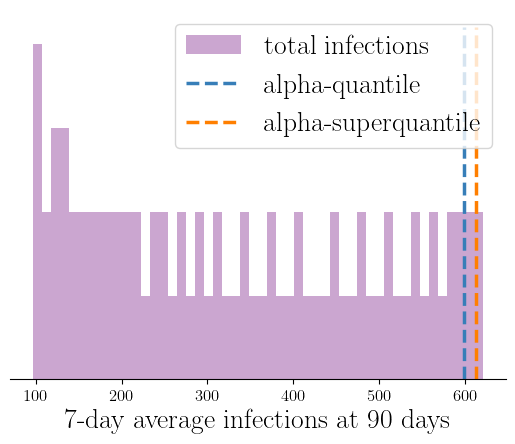

In [30]:
bins_hist = 50
fig1 = plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(Itot_samples_sv, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections')
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(q_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-quantile', color=co[0])
cax.vlines(sq_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', usetex=True, size=20)
cax.legend(loc='upper right', prop={'size': 20})

## Risk-based optimization under uncertainty with intervention on vaccination rate parameter $\nu$
**NOTE:** This is a demonstration of the interface, optimization is not run to convergence nor are enough samples generated to accurately estimate the risk.

In [40]:
from pyciemss.risk.ouu import RandomDisplacementBounds, computeRisk, solveOUU
from pyciemss.risk.qoi import nday_rolling_average
from pyciemss.risk.risk_measures import alpha_superquantile

# Define problem specifics.
RISK_BOUND = 10.
X_MIN = 0.
X_MAX = 0.5
STEPSIZE = 0.005
TOL = 1e-5
MAX_FEVAL = 10
N_SAMPLES = int(1e2)

# Basinhopping kwargs.
T = 1.5
MAXITER = 10
TAKE_STEP = RandomDisplacementBounds(X_MIN, X_MAX, STEPSIZE)

# Control action / intervention.
INIT_ITERATE = np.array([0.05])
INTERVENTION = lambda x: constant_intervention("nu", np.array([x]), new_tspan)
# this should be a torch.tensor() not numpy.array()

# Objective function.
OBJFUN = lambda x: x  # minimize the scalar value itself.

# Define the risk measure.
VAX_RISK = computeRisk(
                        model=ode_model,
                        intervention_fun=INTERVENTION,
                        qoi=nday_rolling_average,
#                         risk_measure=alpha_superquantile,
#                         num_samples=N_SAMPLES,
                        model_state=final_observed_state,
                        tspan=new_tspan,
#                         guide=guide,
#                         compartment="I_obs"
                        )

# Define problem constraints.
CONSTRAINTS = (
                # risk constraint
                {'type': 'ineq', 'fun': lambda x: RISK_BOUND - VAX_RISK(x)},

                # bounds on control
                # NOTE: perhaps use scipy.optimize.LinearConstraint in the future
                {'type': 'ineq', 'fun': lambda x: x - X_MIN},
                {'type': 'ineq', 'fun': lambda x: X_MAX - x}
              )

# move default into class
# Define the settings for the optimizer.
MINIMIZER_KWARGS = dict(
                        constraints=CONSTRAINTS,
                        method="COBYLA",
                        tol=TOL,
                        options={
                                 "disp": False,
                                 "maxiter": MAX_FEVAL
                                },
                       )

### Solve the OUU problem using $\alpha$-superquantile

In [46]:
# Go do the dang thing. Run basinhopping.
print("Performing risk-based optimization under uncertainty ...")
print(f"Estimated wait time {forward_time/1e3*N_SAMPLES*MAXITER*MAX_FEVAL:.0f} seconds.")
# TODO: check ^^ if you wanted to programatically do this
sq_result = solveOUU(
                     x0=INIT_ITERATE,
                     objfun=OBJFUN,
                     constraints=CONSTRAINTS,
#                      minimizer_kwargs=MINIMIZER_KWARGS,
#                      optimizer_algorithm="basinhopping",
#                      T=T,
#                      maxiter=MAXITER,
#                      take_step=TAKE_STEP
                    ).solve()
print("HOT DOG! I'm done optimizing!")

Performing risk-based optimization under uncertainty with ...
Estimated wait time 336 seconds ...
HOT DOG! I'm done optimizing!


### Solve the OUU problem using $\alpha$-quantile

In [45]:
# Define the risk measure.
VAX_RISK = computeRisk(
                        model=ode_model,
                        intervention_fun=INTERVENTION,
                        qoi=nday_rolling_average,
                        risk_measure=alpha_quantile,
                        num_samples=N_SAMPLES,
                        model_state=final_observed_state,
                        tspan=new_tspan,
                        guide=guide,
                        compartment="I_obs"
                        )

# Go do the dang thing. Run basinhopping.
print("Performing risk-based optimization under uncertainty ...")
print(f"Estimated wait time {forward_time/1e3*N_SAMPLES*MAXITER*MAX_FEVAL:.0f} seconds.")
q_result = solveOUU(
                     x0=INIT_ITERATE,
                     objfun=OBJFUN,
                     constraints=CONSTRAINTS,
                     minimizer_kwargs=MINIMIZER_KWARGS,
                     optimizer_algorithm="basinhopping",
                     T=T,
                     maxiter=MAXITER,
                     take_step=TAKE_STEP
                    ).solve()
print("HOT DOG! I'm done optimizing!")

Performing risk-based optimization under uncertainty with ...
Estimated wait time 336 seconds ...
HOT DOG! I'm done optimizing!


## Post process the OUU results for intervention on vaccination rate parameter $\nu$

In [73]:
print(f"Post processing optimization under uncertainty results for intervention on vaccination rate parameter.")

N_SAMPLES = int(1e3)
VAX_RISK.num_samples = N_SAMPLES

sq_samples = VAX_RISK.propagate_uncertainty(np.abs(sq_result.x)) # enforce positivity if non-physical "solution"
sq_qoi = VAX_RISK.qoi(sq_samples)

q_samples = VAX_RISK.propagate_uncertainty(np.abs(q_result.x)) # enforce positivity if non-physical "solution"
q_qoi = VAX_RISK.qoi(q_samples)

Post processing optimization under uncertainty results for intervention on vaccination rate parameter.


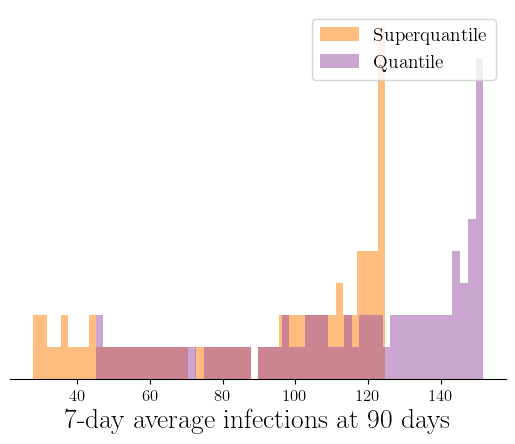

In [79]:
# Make plot
fig1 = plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=18.)

cax = plt.gca()
sideaxishist(cax)

cax.hist(sq_qoi, color=co[1], bins=50, histtype="stepfilled", alpha=0.5, label="Superquantile")
cax.hist(q_qoi, color=co[2], bins=50, histtype="stepfilled", alpha=0.5, label="Quantile")
cax.set_xlabel("7-day average infections at 90 days", size=20)
cax.legend(loc="upper right", prop={"size": 14})

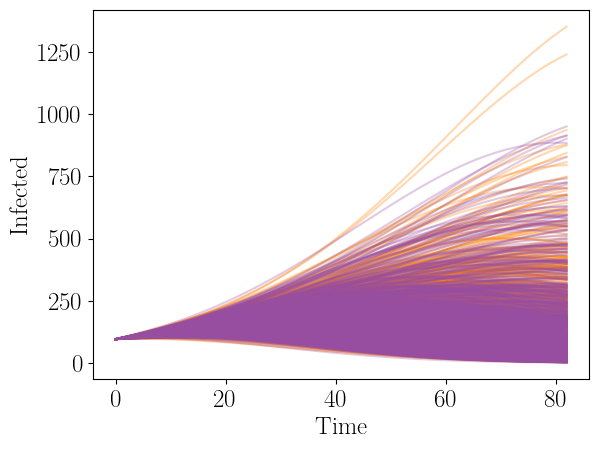

In [95]:
plt.plot(q_samples.T, color=co[1], alpha=0.3, label="Quantile")
plt.plot(sq_samples.T, color=co[2], alpha=0.3, label="Superquantile")
plt.xlabel("Time")
plt.ylabel("Infected")
# plt.legend()
plt.show()
# TODO: think about how to pass gradients for risk metric
# TODO: think about how to incorporate the jacobian of the objective function

In [96]:
q_result

                        fun: 0.001521032700016911
 lowest_optimization_result:      fun: 0.001521032700016911
   maxcv: 139.1584915161133
 message: 'Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.'
    nfev: 10
  status: 4
 success: False
       x: array([0.00152103])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 11
                       nfev: 110
                        nit: 10
                    success: False
                          x: array([0.00152103])

## Risk-based optimization under uncertainty with intervention on flux over next three months
Note that this is not run to convergence and with enough samples to estimate the risk.

In [ ]:
maxfeval=40
maxiter=3
N_SAMPLES=int(1e2)
qoi = 'infections'
control_name = 'svflux'
risk_res = [[] for i in range(2)]

### Using alpha-quantile

In [ ]:
start_time = time.time()
# Set up optimization problem with alpha-quantile
risk_measure='alpha_quantile'
jj=0
print('Performing risk-based OUU with ' + risk_measure + '...')
print('Estimated wait time %s seconds...' % (forward_time/1e3*N_SAMPLES *maxfeval*maxiter))
optprob = OptProblem(twin, quantity_of_interest=qoi, control_name=control_name, risk_measure=risk_measure, 
                     guide=guide, u_bounds=np.array([0., 1e3]), 
                     num_samples=N_SAMPLES, maxfeval=maxfeval, maxiter=maxiter, stepsize=50.)

##### Minimizing vaccination for constraint on risk
risk_bound = 10.
risk_res[jj] = optprob.solve_minvrate(risk_bound=risk_bound, u_init=np.array([400.,200.,10.]))
print('Best vaccination rate under ' + risk_measure + ':')
print(risk_res[jj].x)
print('--- %s seconds for risk-based OUU ---' % (time.time() - start_time))

### Using alpha-superquantile

In [ ]:
start_time = time.time()
# Set up optimization problem with alpha-superquantile
risk_measure='alpha_superquantile'
jj=1
print('Performing risk-based OUU with ' + risk_measure + '...')
print('Estimated wait time %s seconds...' % (forward_time/1e3*N_SAMPLES *maxfeval*maxiter))
optprob = OptProblem(twin, quantity_of_interest=qoi, control_name=control_name, risk_measure=risk_measure, 
                     guide=guide, u_bounds=np.array([0., 1e3]), 
                     num_samples=N_SAMPLES, maxfeval=maxfeval, maxiter=maxiter, stepsize=50.)

##### Minimizing vaccination for constraint on risk
risk_bound = 10.
risk_res[jj] = optprob.solve_minvrate(risk_bound=risk_bound, u_init=np.array([400.,200.,10.]))
print('Best vaccination rate under ' + risk_measure + ':')
print(risk_res[jj].x)
print('--- %s seconds for risk-based OUU ---' % (time.time() - start_time))

### Post-process results for scheduled intervention on flux

In [ ]:
N_SAMPLES_post = int(1e3)
print('Post-processing OUU results for scheduled intervention on flux...')
risk_measures=['alpha_quantile', 'alpha_superquantile']
risk_params=[0.95, 0.95]
out_MC = [[] for i in range(len(risk_measures))]
t_all = [[] for i in range(len(risk_measures))]
samples = [[] for i in range(len(risk_measures))]
qval = [[] for i in range(len(risk_measures))]      # 95-quantiles
qbarval = [[] for i in range(len(risk_measures))]   # 95-superquantile
# # From saved results
# class EmptyStruct:
#     pass
# risk_res[0] = EmptyStruct()
# risk_res[1] = EmptyStruct()
# risk_res[0].x = [393.,25.,0.]
# risk_res[1].x = [397.,96.,29.]
for jj, risk_met in enumerate(risk_measures):
    twin.control = Control_pyro().scheduled_vaccination(risk_res[jj].x)            
    out_MC[jj], _, t_all[jj] = twin.forwardUQsv_pyro(num_samples=N_SAMPLES_post, tf=tf, guide=guide, rseed=1)
    # Get samples of total infections for each day
    samples[jj] = decision_metric_samples(out_MC[jj]['Itot'], tf=tf, metric=decision_metric, dt=1.)
    # Estimate risk
    qval[jj] = getattr(Risk(samples[jj]),'alpha_quantile')(0.95)
    qbarval[jj] = getattr(Risk(samples[jj]),'alpha_superquantile')(0.95)
    print(risk_met, risk_res[jj].x, qval[jj], qbarval[jj])

########## Plot I_total distribution
fig1 = plt.figure()
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
for jj, risk_met in enumerate(risk_measures):
    cax.hist(samples[jj], color=co[jj+1], bins=50, histtype='stepfilled', alpha=0.5, label=rlabel[jj])
cax.set_xlabel('7-day average infections at 90 days', usetex=True, size=20)
cax.legend(loc="upper right", prop={'size': 14})